In [133]:
# imports

import os
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from report_writer import ReportWriter
from utils import get_info

In [134]:

# important folders in this excercise

RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

## Download the data file

In [135]:
FILE_URL ='https://raw.githubusercontent.com/propublica/compas-analysis/refs/heads/master/compas-scores-two-years.csv'
FILE_NAME = 'compas-scores-two-years.csv'

# file is small, i will not chunk

if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

if not os.path.exists(os.path.join(DATA_FOLDER, FILE_NAME)):
    import urllib.request
    urllib.request.urlretrieve(FILE_URL, os.path.join(DATA_FOLDER, FILE_NAME))



In [136]:
# load data file located in compass-analysis folder

data_file_path = os.path.join(DATA_FOLDER, 'compas-scores-two-years.csv')
df = pd.read_csv(data_file_path)
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (7214, 53)


## First look at the data

We look at the dataset, storing all the results in excel. in this step we will
- look at the dataframe information
- capture the first 5 rows
- look at information regarding numerical fields, min. max etc


In [137]:

report_file_path = os.path.join(RESULTS_FOLDER, 'initial_analysis_report.xlsx')

rep_writer = ReportWriter(report_file_path)

# what are the data types
rep_writer.add_data_frame(get_info(df), 'data_types')

# look at first 5 rows in dataset
rep_writer.add_data_frame(df.head(), 'first_5_rows')

# summerize numerical vals
rep_writer.add_data_frame(df.describe(), 'numerical_summary')

rep_writer.save()

## Missing Values Handling

In [138]:
import os
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt

threshold = 0.5

# Original column names
original_columns = df.columns

# Drop columns below threshold
df_cleaned = df.dropna(axis=1, thresh=int(threshold * len(df)))

# Identify dropped columns
dropped_columns = original_columns.difference(df_cleaned.columns)
rep_writer.add_data_frame(pd.DataFrame(dropped_columns, columns=["Dropped Columns"]), 'dropped_columns')


# Calculate missing data percentages
missing_before = df.isnull().mean() * 100
missing_after = df_cleaned.isnull().mean() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before cleaning
axes[0].barh(missing_before.index, missing_before.values, color='dodgerblue')
axes[0].set_title("Missing Data Before Cleaning")
axes[0].set_xlabel("Percentage of Missing Values")
axes[0].set_xlim(0, 100)

# After cleaning
axes[1].barh(missing_after.index, missing_after.values, color='seagreen')
axes[1].set_title("Missing Data After Cleaning")
axes[1].set_xlabel("Percentage of Missing Values")
axes[1].set_xlim(0, 100)

# Clean up axes
for ax in axes:
    ax.invert_yaxis()  # Invert for better readability

plt.tight_layout()

# Save the combined plot
combined_plot_path = os.path.join(TEMP_FOLDER, 'missing_data_barplot.png')
plt.savefig(combined_plot_path, dpi=300)
plt.close()

# Add the combined plot to the report
rep_writer.add_current_plt(combined_plot_path, 'missing_data_barplot')
rep_writer.save()



## Reduce the dataset to the necessary columns

In [139]:
# List of columns needed for data analysis
needed_columns = [
    "compas_screening_date", "sex", "age", "age_cat", "race", 
    "juv_misd_count", "juv_fel_count", "juv_other_count", 
    "priors_count", "days_b_screening_arrest", "c_charge_degree", 
    "two_year_recid", "decile_score", "score_text"
]

# Reduce the dataset to only the needed columns
df_reduced = df_cleaned[needed_columns]

reduced_file_path = os.path.join(DATA_FOLDER, 'reduced_dataset.csv')
df_reduced.to_csv(reduced_file_path, index=False)


In [140]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   compas_screening_date    7214 non-null   object 
 1   sex                      7214 non-null   object 
 2   age                      7214 non-null   int64  
 3   age_cat                  7214 non-null   object 
 4   race                     7214 non-null   object 
 5   juv_misd_count           7214 non-null   int64  
 6   juv_fel_count            7214 non-null   int64  
 7   juv_other_count          7214 non-null   int64  
 8   priors_count             7214 non-null   int64  
 9   days_b_screening_arrest  6907 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  two_year_recid           7214 non-null   int64  
 12  decile_score             7214 non-null   int64  
 13  score_text               7214 non-null   object 
dtypes: float64(1), int64(7),

## Imputation of missing days_b_screening_arrest  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   compas_screening_date    7214 non-null   object 
 1   sex                      7214 non-null   object 
 2   age                      7214 non-null   int64  
 3   age_cat                  7214 non-null   object 
 4   race                     7214 non-null   object 
 5   juv_misd_count           7214 non-null   int64  
 6   juv_fel_count            7214 non-null   int64  
 7   juv_other_count          7214 non-null   int64  
 8   priors_count             7214 non-null   int64  
 9   days_b_screening_arrest  7214 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  two_year_recid           7214 non-null   int64  
 12  decile_score             7214 non-null   int64  
 13  score_text               7214 non-null   object 
dtypes: float64(1), int64(7),

C:\Users\carme\AppData\Local\Temp\ipykernel_24244\2464486596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[target_column] = df_subset_imputed[target_column]


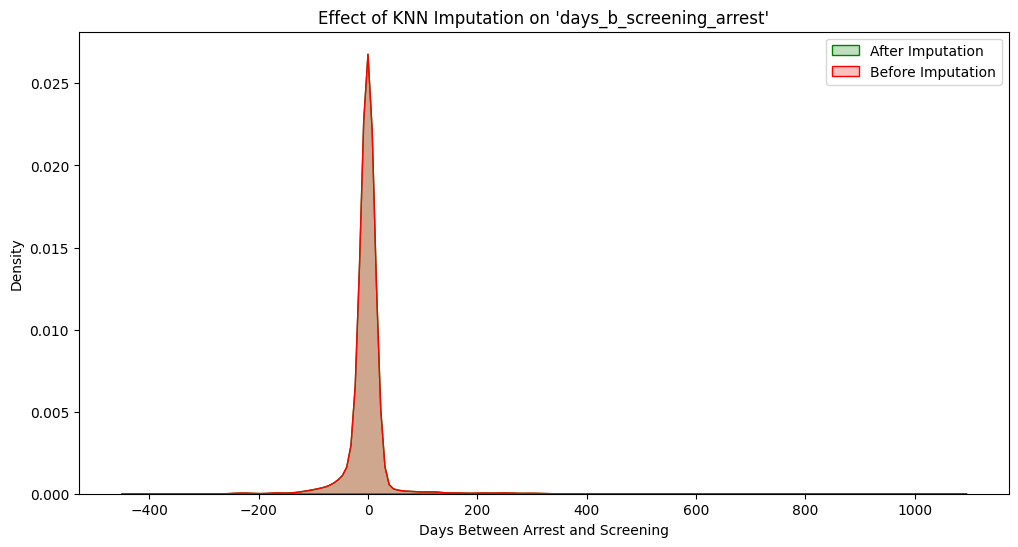

In [ ]:

df_reduced_copy = df_reduced.copy() 

# Columns to use as predictors for KNN Imputation (numeric only)
predictor_columns = ["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "two_year_recid", "decile_score"]

# Target column to fill
target_column = "days_b_screening_arrest"

# Combine the predictors and target column into a separate DataFrame
df_subset = df_reduced[predictor_columns + [target_column]]

# Apply KNN Imputer only to the subset
imputer = KNNImputer(n_neighbors=5)
df_subset_imputed = pd.DataFrame(imputer.fit_transform(df_subset), columns=df_subset.columns)

# Replace only the target column in the original DataFrame
df_reduced[target_column] = df_subset_imputed[target_column]

imputed_file_path = os.path.join(DATA_FOLDER, 'imputed_dataset.csv')
df_reduced.to_csv(imputed_file_path, index=False)




# Plot distributions before and after imputation
plt.figure(figsize=(12, 6))
sns.kdeplot(df_reduced[target_column], label="After Imputation", color="green", fill=True)
sns.kdeplot(df_reduced_copy[target_column], label="Before Imputation", color="red", fill=True)
plt.title("Effect of KNN Imputation on 'days_b_screening_arrest'")
plt.xlabel("Days Between Arrest and Screening")
plt.ylabel("Density")
plt.legend()
plt.show()



In [159]:
print(df_reduced.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   compas_screening_date    7214 non-null   object 
 1   sex                      7214 non-null   object 
 2   age                      7214 non-null   int64  
 3   age_cat                  7214 non-null   object 
 4   race                     7214 non-null   object 
 5   juv_misd_count           7214 non-null   int64  
 6   juv_fel_count            7214 non-null   int64  
 7   juv_other_count          7214 non-null   int64  
 8   priors_count             7214 non-null   int64  
 9   days_b_screening_arrest  7214 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  two_year_recid           7214 non-null   int64  
 12  decile_score             7214 non-null   int64  
 13  score_text               7214 non-null   object 
 14  stratify_column         

### Take care of categorical data

In [164]:
print(df_reduced['sex'].value_counts())
print(df_reduced['race'].value_counts())
print(df_reduced['age_cat'].value_counts())
print(df_reduced['c_charge_degree'].value_counts())
print(df_reduced['score_text'].value_counts())



sex
Male      5819
Female    1395
Name: count, dtype: int64
race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64
age_cat
25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: count, dtype: int64
c_charge_degree
F    4666
M    2548
Name: count, dtype: int64
score_text
Low       3897
Medium    1914
High      1403
Name: count, dtype: int64


In [169]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Copy the original dataset
df_encoded = df_reduced.copy()

# onehot encoding
ohe_features = ['sex', 'race', 'c_charge_degree']

ohe = OneHotEncoder()
df_ohe = pd.DataFrame(ohe.fit_transform(df_encoded[ohe_features]).toarray(), columns=ohe.get_feature_names_out(ohe_features))
df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

# ordinal encoding
oe_features = ['age_cat', 'score_text']
age_cat_order = ['Less than 25', '25 - 45', 'Greater than 45']
score_text_order = ['Low', 'Medium', 'High']

ordinal_encoder = OrdinalEncoder(categories=[age_cat_order, score_text_order])
df_encoded[['age_cat_encoded', 'score_text_encoded']] = ordinal_encoder.fit_transform(
    df_encoded[['age_cat', 'score_text']]
)


encoded_file_path = os.path.join(DATA_FOLDER, 'encoded_dataset.csv')
df_encoded.to_csv(encoded_file_path, index=False)

In [170]:
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   compas_screening_date    7214 non-null   object 
 1   sex                      7214 non-null   object 
 2   age                      7214 non-null   int64  
 3   age_cat                  7214 non-null   object 
 4   race                     7214 non-null   object 
 5   juv_misd_count           7214 non-null   int64  
 6   juv_fel_count            7214 non-null   int64  
 7   juv_other_count          7214 non-null   int64  
 8   priors_count             7214 non-null   int64  
 9   days_b_screening_arrest  7214 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  two_year_recid           7214 non-null   int64  
 12  decile_score             7214 non-null   int64  
 13  score_text               7214 non-null   object 
 14  stratify_column         

## Test / Train / Dev split

In [173]:

from sklearn.model_selection import StratifiedShuffleSplit

# Define the target column for stratification (race)
stratify_column = 'race'

# Set up StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Create train and test sets
for train_idx, test_idx in split.split(df_encoded, df_encoded[stratify_column]):
    df_train = df_encoded.iloc[train_idx]
    df_test = df_encoded.iloc[test_idx]

# Further split test into dev and test (50/50 split)
split_dev = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_idx, dev_idx in split_dev.split(df_test, df_test[stratify_column]):
    df_test_final = df_test.iloc[test_idx]
    df_dev = df_test.iloc[dev_idx]

# Function to print race counts and percentages
def print_race_distribution(df, name):
    print(f"\n{name} Dataset:")
    race_counts = df['race'].value_counts()
    race_percentages = (race_counts / len(df)) * 100
    print(f"Percentages by Race:\n{race_percentages.round(2)}")

# Print results for train, test, and dev sets
print_race_distribution(df_train, "Train")
print_race_distribution(df_test_final, "Test")
print_race_distribution(df_dev, "Dev")

df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_test_path = os.path.join(DATA_FOLDER, 'test_dataset.csv')
df_dev_path = os.path.join(DATA_FOLDER, 'dev_dataset.csv')

df_train.to_csv(df_train_path, index=False)
df_test_final.to_csv(df_test_path, index=False) 
df_dev.to_csv(df_dev_path, index=False)




Train Dataset:
Percentages by Race:
race
African-American    51.24
Caucasian           34.01
Hispanic             8.82
Other                5.23
Asian                0.45
Native American      0.24
Name: count, dtype: float64

Test Dataset:
Percentages by Race:
race
African-American    51.18
Caucasian           33.98
Hispanic             8.88
Other                5.27
Asian                0.42
Native American      0.28
Name: count, dtype: float64

Dev Dataset:
Percentages by Race:
race
African-American    51.25
Caucasian           34.07
Hispanic             8.86
Other                5.12
Asian                0.42
Native American      0.28
Name: count, dtype: float64
